# Data Preprocessing

## Required Modules

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import librosa
import librosa.display
import pandas as pd
import mediapipe as mp

## Pose Data Extraction from Dance Videos

This section outlines the methodology for extracting pose data from a dance video upon user upload. The process is divided into the following key steps:

**Step 1**: Decompose the video into individual frames. We capture pose data at regular intervals, tentatively set at every quarter second; however, this frequency is subject to adjustment based on precision requirements.

**Step 2**: Apply the MediaPipe model to the extracted frames to identify pose landmarks. Frames that do not yield landmark data will be excluded from the analysis.

**Step 3**: Compile the extracted pose coordinates into a structured dataset for subsequent analysis.

In [2]:
## Step 1

def extract_image_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = 0.25 * fps
    frame_count = 0
    image_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            if frame_count % interval < 1:
                cv2.imwrite(f'data/processed/user_video1/{frame_count:05d}.png', frame)
                image_count += 1
            frame_count += 1
        else:
            break
    cap.release()
    print(f"Total frames extracted: {image_count}, Total frame count {frame_count}, {fps}")

video_path = 'data/external/user_video1.mp4'
extract_image_from_video(video_path)

Total frames extracted: 747, Total frame count 5600, 30.0


In [6]:
## Step 2

def extract_pose_into_dictionary(input_dir):
    
    mp_pose = mp.solutions.pose.Pose(min_detection_confidence=0.1, min_tracking_confidence=0.1, model_complexity=2)
    filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".png")]
    filenames.sort()
    pose_data = []

    for image_file_path in filenames:
        image = cv2.imread(image_file_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = mp_pose.process(rgb_image)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            pose_info = {'filename': image_file_path}
            for j, landmark in enumerate(landmarks):
                index_str = str(j).zfill(2)  # Zero-pad the index to two digits
                pose_info[f'landmark_{index_str}_x'] = landmark.x
                pose_info[f'landmark_{index_str}_y'] = landmark.y
                pose_info[f'landmark_{index_str}_z'] = landmark.z
                pose_info[f'landmark_{index_str}_v'] = landmark.visibility
            pose_data.append(pose_info)
        else:
            print(f"No pose landmarks detected in {image_file_path}")

    return pd.DataFrame(pose_data)

In [7]:
## Step 3

user_video1 = extract_pose_into_dictionary('data/processed/user_video1')
user_video1.to_csv('data/testing/uservideo1.csv')
user_video1.head()

I0000 00:00:1701822678.002427       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.28), renderer: Intel(R) Iris(TM) Plus Graphics 655
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


No pose landmarks detected in data/processed/user_video1/02333.png
No pose landmarks detected in data/processed/user_video1/02370.png
No pose landmarks detected in data/processed/user_video1/04163.png
No pose landmarks detected in data/processed/user_video1/04538.png
No pose landmarks detected in data/processed/user_video1/04763.png
No pose landmarks detected in data/processed/user_video1/05543.png


,filename,landmark_00_x,landmark_00_y,landmark_00_z,landmark_00_v,landmark_01_x,landmark_01_y,landmark_01_z,landmark_01_v,landmark_02_x,...,landmark_30_z,landmark_30_v,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_v,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_v
0,data/processed/user_video1/00000.png,0.410198,0.349696,0.358313,0.998476,0.406418,0.342147,0.352502,0.998804,0.404296,...,-0.144430,0.904075,0.303013,0.807678,-0.138454,0.579783,0.399698,0.826966,-0.190566,0.442701
1,data/processed/user_video1/00008.png,0.419352,0.360204,0.294807,0.998627,0.414449,0.352206,0.290885,0.998923,0.412133,...,-0.153866,0.912060,0.218755,0.658397,0.046494,0.577436,0.405687,0.832140,-0.195573,0.487099
2,data/processed/user_video1/00015.png,0.445259,0.366773,0.226127,0.998763,0.439919,0.361446,0.241070,0.999030,0.438569,...,-0.195745,0.920548,0.258489,0.715070,0.122943,0.607940,0.406368,0.838121,-0.261970,0.537764
3,data/processed/user_video1/00023.png,0.472257,0.391978,0.146283,0.998875,0.469676,0.384386,0.164756,0.999120,0.469214,...,-0.224262,0.925765,0.344507,0.740708,-0.001276,0.630308,0.407047,0.838285,-0.288967,0.582260
4,data/processed/user_video1/00030.png,0.492078,0.382611,-0.016008,0.997569,0.496181,0.377079,0.004417,0.997320,0.498196,...,-0.175351,0.880078,0.468573,0.744594,-0.030936,0.606597,0.464542,0.790293,-0.266510,0.595557


## Visualize Results

In [8]:
def plot_pose_dictionary_entry(df,index):
    
    x_columns = sorted([col for col in df.columns if col.endswith('_x')])
    y_columns = sorted([col for col in df.columns if col.endswith('_y')])
    x = df[x_columns].iloc[index].to_numpy()
    y = df[y_columns].iloc[index].to_numpy()

    head_x, head_y = x[0:10].mean(), y[0:10].mean()
    upper_torso_x, upper_torso_y = x[[11, 12]].mean(), y[[11, 12]].mean()        
    hip_x, hip_y = x[23:24].mean(), y[23:24].mean()

    # Right Leg
    knee_right_x = x[26]
    knee_right_y = y[26]
    foot_right_x = x[[28, 30, 32]].mean()
    foot_right_y = y[[28, 30, 32]].mean()

    # Left Leg
    knee_left_x = x[25]
    knee_left_y = y[25]
    knees_x, knees_y = x[25:26].mean(), y[25:26].mean()

    
    foot_left_x = x[[27, 29, 31]].mean()
    foot_left_y = y[[27, 29, 31]].mean()

    foot_x = (foot_left_x + foot_right_x) / 2
    foot_y = (foot_left_y + foot_right_y) / 2

    alignment_x = [head_x, upper_torso_x, hip_x]
    alignment_y = [head_y, upper_torso_y, hip_y]

    hip_knee_right_x = [hip_x,knee_right_x]
    hip_knee_right_y = [hip_y,knee_right_y]

    hip_knee_left_x = [hip_x,knee_left_x]
    hip_knee_left_y = [hip_y,knee_left_y]

    lower_alignment_left_x = [knee_left_x, foot_left_x]
    lower_alignment_left_y = [knee_left_y, foot_left_y]

    lower_alignment_right_x = [knee_right_x, foot_right_x]
    lower_alignment_right_y = [knee_right_y, foot_right_y]


    filename = df['filename'].iloc[index]
    filename_img = cv2.imread(filename)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(filename)
    axes[0].imshow(filename_img)
    axes[0].axis('off')

    axes[1].set_title("Pose X,Y")
    axes[1].plot(alignment_x, alignment_y, color=mcolors.CSS4_COLORS['lightsteelblue'], label="spine", marker='_', alpha=0.5)
    axes[1].plot(lower_alignment_left_x, lower_alignment_left_y, color=mcolors.CSS4_COLORS['lightsteelblue'], label="spine", marker='_', alpha=0.5)
    axes[1].plot(lower_alignment_right_x, lower_alignment_right_y, color=mcolors.CSS4_COLORS['lightsteelblue'], label="spine", marker='_', alpha=0.5)
    axes[1].plot(hip_knee_right_x, hip_knee_right_y, color=mcolors.CSS4_COLORS['lightsteelblue'], label="spine", marker='_', alpha=0.5)
    axes[1].plot(hip_knee_left_x, hip_knee_left_y, color=mcolors.CSS4_COLORS['lightsteelblue'], label="spine", marker='_', alpha=0.5)
    
    axes[1].plot(head_x, head_y, color=mcolors.CSS4_COLORS['red'], label="head", marker='P')
    axes[1].plot(upper_torso_x, upper_torso_y, color=mcolors.CSS4_COLORS['cyan'], label="upper torso", marker='P')
    axes[1].plot(hip_x, hip_y, color=mcolors.CSS4_COLORS['blue'], label="hips", marker='P')
    axes[1].plot(knee_right_x, knee_right_y, color=mcolors.CSS4_COLORS['green'], label="Knee R", marker='P')
    axes[1].plot(foot_right_x, foot_right_y, color=mcolors.CSS4_COLORS['green'], label="feet R", marker='P')
    axes[1].plot(knee_left_x, knee_left_y, color=mcolors.CSS4_COLORS['magenta'], label="Knee L", marker='P')
    axes[1].plot(foot_left_x, foot_left_y, color=mcolors.CSS4_COLORS['magenta'], label="feet L", marker='P')
    axes[1].set_xlabel("x-axis")
    axes[1].set_ylabel("y-axis")
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].invert_yaxis()
    axes[1].grid()

    fig.tight_layout()
    plt.show()


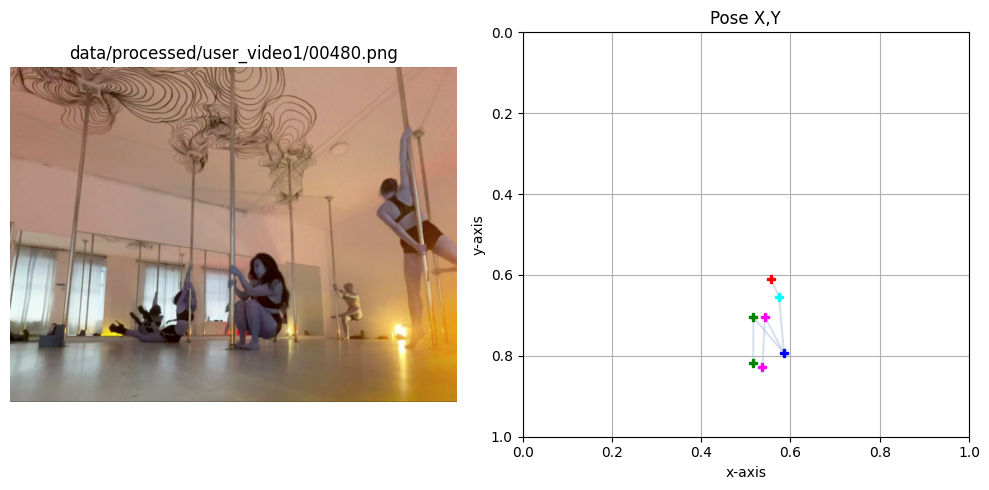

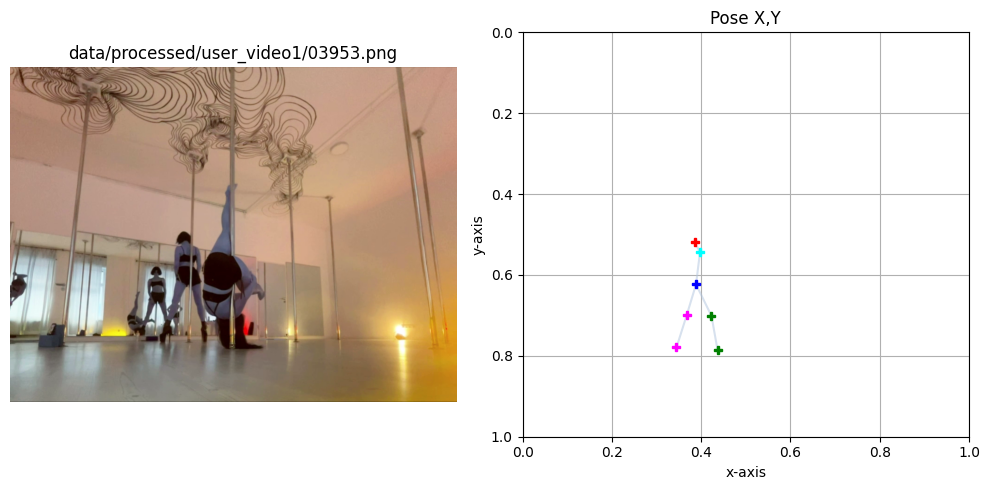

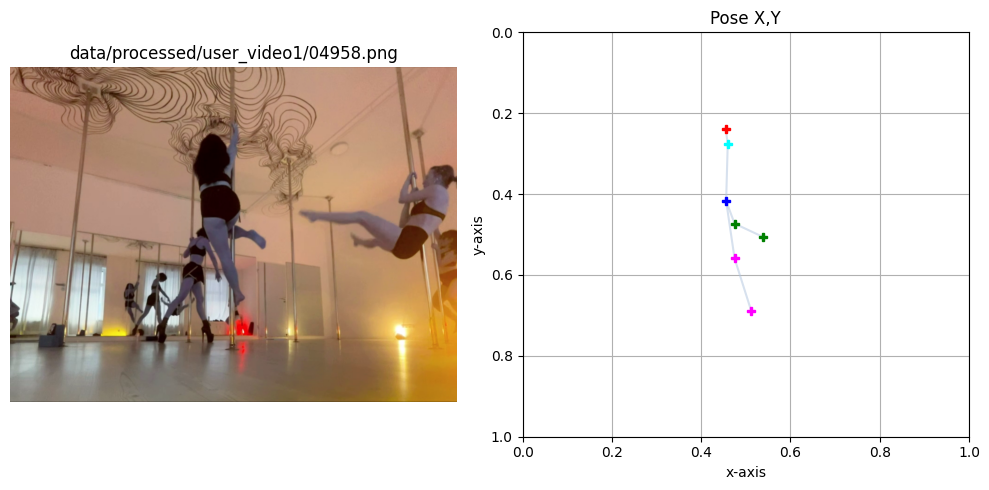

In [13]:
import random
random_numbers = random.sample(range(len(user_video1)), 3)
random_numbers

for i in random_numbers:
    plot_pose_dictionary_entry(user_video1,i)

## References

* https://github.com/google/mediapipe